## Тестовое задание для вакансии Junior Data Scientist
### Илларионов Артем

В рамках исследовательской задачи мы проанализируем данные о поездках в такси Нью-Йорка в декабре 2019 и январе 2020. После чего предстоить ответить на следующие вопросы. 

- Как стоимость поездки скоррелирована с другими факторами? Как вы это можете объяснить?
- Найдите аномальные поездки. Почему именно эти поездки вы считаете аномальными?
- Постройте распределение по стоимости поездок. Проверьте гипотезу о том, что оно имеет нормальное распределение. Как вы можете это объяснить?
- Из данных постройте модель, которая описывает тариф (т.е. стоимость поездки от других факторов).
- Используя модель из пункта выше ответьте на вопрос: были ли в какие-то дни (или временные промежутки) скидки или акции? И если были, то как вы можете это объяснить.

#### *В качестве исходных данных будем использовать "Yellow Taxi Trip Records" за 2019/12 и 2020/01*
https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

The yellow and green taxi trip records include fields capturing:
- pick-up and drop-off dates/times
- pick-up and drop-off locations
- trip distances
- itemized fares
- rate types
- payment types
- driver-reported passenger counts

## 1. Импорт библиотек и данных

In [1]:
#conda install -c conda-forge xgboost

In [2]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime, timedelta
from collections import Counter
from pandas import Series
import gc

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
sns.set() # стандартные параметры отображения графиков Seaborn
import plotly.graph_objects as go

# Feature Engineering
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.feature_selection import f_regression

# ML
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xg
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score

pd.set_option('display.max_columns', None)
pd.set_option("display.float_format", "{:.3f}".format)

In [3]:
# Фиксируем для воспроизводимости
random_seed = 42
!pip freeze > requirements.txt

In [5]:
# Загрузка датасетов
DATA_DIR = 'C:/.../test taxi'

df = pd.read_csv(DATA_DIR+'/yellow_tripdata_2019-12.csv')
df_0120 = pd.read_csv(DATA_DIR+'/yellow_tripdata_2020-01.csv')

# Объединим данные в единый датасет
df['month'] = 'december'
df_0120['month'] = 'january'
df = df.append(df_0120, sort=False).reset_index(drop=True)

del df_0120, DATA_DIR
gc.collect()

print('df shape: ', df.shape)

df shape:  (13301325, 19)


***Подготовка функций***

In [6]:
# Для категориальных переменных подготовим функцию, 
# которая будет считать и демонстрировать процентное распределение значений
def ord_proport(factor):
    print(f'\nПоказатель: {factor}')
    proportion = df[factor].value_counts(dropna=False, normalize=True)
    display(proportion)
    figure = plt.subplots(figsize=(5, 2))  # Добавим компактную гистограмму
    plt.hist(df[factor])
    plt.title(factor)
    plt.show() 

# Для количественных переменных - основные параметры распределения и boxplot по месяцам
def describe_and_boxplot(factor):
    print(f'\nПоказатель: {factor}')
    display(df[factor].describe())
    sns.boxplot(x='month', y=factor, data=df);
    
# Расчёт верхней границы допустимых значений
def outliers(factor):
    print(f'\nВычислим границу выбросов для показателя {factor} по среднему значению + 3 стандартных отклонения')
    upper_border = int(df[factor].describe()['mean'] + 3 * df[factor].describe()['std']) + 1
    print(f'Верхний предел {factor} - {upper_border}')
    outliers_sum = len(df[df[factor] >= upper_border])
    print(f'Количество выбросов по данному признаку - {outliers_sum} или {round(outliers_sum/len(df)*100, 1)}%')

## 2. Анализ исходных данных

In [7]:
df.head(2)

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0     1.000  2019-12-01 00:26:58   2019-12-01 00:41:45            1.000   
1     1.000  2019-12-01 00:12:08   2019-12-01 00:12:14            1.000   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0          4.200       1.000                  N           142           116   
1          0.000       1.000                  N           145           145   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0         2.000       14.500  3.000    0.500       0.000         0.000   
1         2.000        2.500  0.500    0.500       0.000         0.000   

   improvement_surcharge  total_amount  congestion_surcharge     month  
0                  0.300        18.300                 2.500  december  
1                  0.300         3.800                 0.000  december

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13301325 entries, 0 to 13301324
Data columns (total 19 columns):
VendorID                 float64
tpep_pickup_datetime     object
tpep_dropoff_datetime    object
passenger_count          float64
trip_distance            float64
RatecodeID               float64
store_and_fwd_flag       object
PULocationID             int64
DOLocationID             int64
payment_type             float64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
congestion_surcharge     float64
month                    object
dtypes: float64(13), int64(2), object(4)
memory usage: 1.9+ GB


In [9]:
df.isna().sum()

VendorID                 116459
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          116459
trip_distance                 0
RatecodeID               116459
store_and_fwd_flag       116459
PULocationID                  0
DOLocationID                  0
payment_type             116459
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge          0
month                         0
dtype: int64

Учитывая, что доля записей, содержащих пропуски в данных, оносительно невелика, для простоты удалим их из датасета.

In [7]:
df.dropna(inplace=True)
print('Новая длина df: ', len(df))

Новая длина df:  13184866


Теперь рассмотрим в отдельности все имеющиеся признаки.

### 2.1. total_amount
#### Начнём с целевой переменной - общей стоимости поездки, которая является суммой нескольких показателей: 
- fare_amount	
- extra	
- mta_tax	
- tip_amount	
- tolls_amount	
- improvement_surcharge


Показатель: total_amount


count   13184866.000
mean          19.008
std          110.766
min        -1472.800
25%           11.270
50%           14.750
75%           20.300
max       398471.200
Name: total_amount, dtype: float64

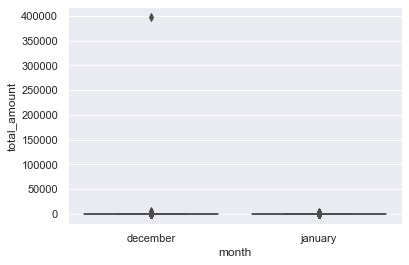

In [11]:
describe_and_boxplot('total_amount')

Очевидно, в данных есть выбросы как в большую, так и в меньшую сторону. При этом, одна поездка чрезвычайно выделяется по стоимости.

In [12]:
df[df.total_amount > 50000]

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
3812021     1.000  2019-12-16 15:37:05   2019-12-16 15:51:05            1.000   

         trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
3812021          0.000       1.000                  Y           236   

         DOLocationID  payment_type  fare_amount  extra  mta_tax  tip_amount  \
3812021           237         4.000   398468.380  2.500    0.320       0.000   

         tolls_amount  improvement_surcharge  total_amount  \
3812021         0.000                  0.000    398471.200   

         congestion_surcharge     month  
3812021                 2.500  december

По прочим показателям ничего необычного, так что удаляем эту аномальную запись и ещё раз взглянем на выбивающиеся суммы.

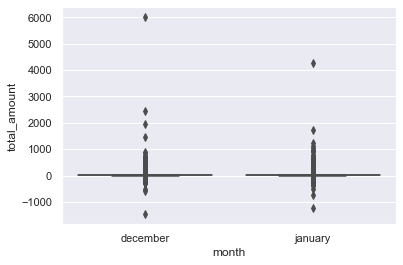

In [8]:
df.drop(df[df.total_amount > 50000].index, inplace=True)
sns.boxplot(x='month', y='total_amount', data=df);

Посмотрим на примеры очень высоких списаний.

In [14]:
df[df.total_amount > 1500]

VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
513922       1.000  2019-12-03 15:00:58   2019-12-03 15:18:04   
2772387      2.000  2019-12-12 14:53:37   2019-12-16 09:45:42   
3078426      2.000  2019-12-13 16:45:59   2019-12-14 10:04:54   
10945860     2.000  2020-01-21 15:38:33   2020-01-27 13:43:40   
11955611     2.000  2020-01-26 00:51:39   2020-01-28 07:18:59   

          passenger_count  trip_distance  RatecodeID store_and_fwd_flag  \
513922              1.000          0.200       1.000                  N   
2772387             1.000          1.070       1.000                  N   
3078426             1.000          0.000       1.000                  N   
10945860            1.000          1.570       1.000                  N   
11955611            1.000         58.850       1.000                  N   

          PULocationID  DOLocationID  payment_type  fare_amount  extra  \
513922             238           141         2.000     6012.500  2.500   
2772387            193           193         2.000     2442.500  0.800   
3078426            193           193         2.000     1961.500  1.000   
10945860           186           152         2.000     4265.000  0.000   
11955611           132             7         2.000     1718.500  0.500   

          mta_tax  tip_amount  tolls_amount  improvement_surcharge  \
513922      0.500       0.000         0.000                  0.300   
2772387     0.500       0.000         0.000                  0.000   
3078426     0.500       0.000         0.000                  0.300   
10945860    0.500       0.000         0.000                  0.300   
11955611    0.500       0.000         0.000                  0.300   

          total_amount  congestion_surcharge     month  
513922        6015.800                 2.500  december  
2772387       2443.800                 0.000  december  
3078426       1965.800                 2.500  december  
10945860      4268.300                 2.500   january  
11955611      1722.300                 2.500   january

Почти в каждом случае есть признаки некорректной тарификации.

- 1 строка - Счётчик накрутил 6 тыс. usd за 17 минут
- 2 строка - Поездка длилась 3.5 дня (маршрут всего 1.1 мили в рамках одной тарифной зоны)
- 3 строка - За несколько часов не изменилась ни тарифная зона, ни пробег
- 4 строка - 1.57 мили за почти 6 суток
- 5 строка - Тут интереснее. Счётчик работал 2 суток, и поездка вышла почти 95 км. Странный случай, похожий на ошибку, но пока оставим.

In [9]:
df.drop(df[df.total_amount > 1800].index, inplace=True)

Далее проводить построчную проверку не имеет смысла. Очевидно, датасет содержит аномальные и некорректные данные. Перейдём к рассмотрению отдельных признаков, составляющие total_amount и, где возможно, скорректируем.

#### 2.1.A. fare_amount
The time-and-distance fare calculated by the meter.

In [16]:
df.fare_amount.describe()

count   13184861.000
mean          12.958
std           12.157
min        -1472.000
25%            6.500
50%            9.500
75%           14.500
max         1718.500
Name: fare_amount, dtype: float64

Рассмотрим самое дорогое значение fare_amount.

In [17]:
df[df.fare_amount == df.fare_amount.max()]

VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
11955611     2.000  2020-01-26 00:51:39   2020-01-28 07:18:59   

          passenger_count  trip_distance  RatecodeID store_and_fwd_flag  \
11955611            1.000         58.850       1.000                  N   

          PULocationID  DOLocationID  payment_type  fare_amount  extra  \
11955611           132             7         2.000     1718.500  0.500   

          mta_tax  tip_amount  tolls_amount  improvement_surcharge  \
11955611    0.500       0.000         0.000                  0.300   

          total_amount  congestion_surcharge    month  
11955611      1722.300                 2.500  january

Эту запись мы уже видели - более 2 суток в пути и 59 миль (95 км) невыключающегося счётчика. Fare_amount составляет наибольшую долю от общей стоимости поездки, и скорее всего, имеет сильную корреляцию с пройденной дистанцией. 

Перейдём к рассмотрению отрицательных сумм. Счётчик не может крутиться в обратном направлении, и никакие скидки и акции не могут идти в убыток компании. 

In [18]:
len(df[df.fare_amount < 0]) # общее количество отрицательных начислений

40254

In [19]:
# Пример соседних с отрицательной записью строк
sample_indexes = [1414188,1414189]
df[df.index.isin(sample_indexes)]

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
1414188     2.000  2019-12-06 23:34:02   2019-12-06 23:34:09            3.000   
1414189     2.000  2019-12-06 23:34:02   2019-12-06 23:34:09            3.000   

         trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
1414188          0.000       1.000                  N           132   
1414189          0.000       1.000                  N           132   

         DOLocationID  payment_type  fare_amount  extra  mta_tax  tip_amount  \
1414188           264         3.000       -2.500 -0.500   -0.500       0.000   
1414189           264         2.000        2.500  0.500    0.500       0.000   

         tolls_amount  improvement_surcharge  total_amount  \
1414188         0.000                 -0.300        -3.800   
1414189         0.000                  0.300         3.800   

         congestion_surcharge     month  
1414188                 0.000  december  
1414189                 0.000  december

 Похоже, что отрицательные записи могут являться **возвратом** идентичной суммы той же поездки.

In [20]:
display(df[df.fare_amount < 0].groupby('payment_type')['fare_amount'].count())
display(df[df.fare_amount < 0].groupby('payment_type')['fare_amount'].sum())

payment_type
1.000       42
2.000     7289
3.000    14420
4.000    18503
Name: fare_amount, dtype: int64

payment_type
1.000      -506.300
2.000   -126074.010
3.000   -140796.970
4.000   -232938.840
Name: fare_amount, dtype: float64

По количеству и сумме возвратов наиболее частые типы платежа - 3 (No charge) и 4 (Dispute). Но немало и по кредитной карте. Теоретически, бесплатными поездками могли быть временные акции. Поэтому, в дальнейшем стоит обратить на это внимание. 

#  !  # 
***Сделать ключ, который будет уникальным для обыкновенной поездки, и будет дублироваться в датасете в случае наличия возвратов.*** Далее по этому ключу value_counts - в словарь. Смэппить признак в датасет. Там, где 1 - это обычная поездка, где 2 -  признак наличия возврата и затем можно удалять все отрицательные списания.  

#### 2.1.B. Extra
Miscellaneous extras and surcharges. Currently, this only includes the 0.50 USD and 1.00 USD rush hour and overnight charges.

In [21]:
df.extra.value_counts()

0.000      4958069
0.500      2610422
2.500      2212103
1.000      1502931
3.000      1095262
3.500       721578
4.500        45489
7.000        16813
-0.500       13332
-1.000        5735
0.800         1283
1.300          589
-4.500         510
1.800          409
2.000          120
0.300           87
2.800           26
-2.000          13
87.560           9
-2.500           9
5.000            8
5.300            7
20.200           7
-3.500           4
2.050            3
-3.000           3
-0.800           3
1.020            3
27.600           3
2.950            2
9.500            2
7.500            2
90.060           2
2.560            1
9.400            1
26.700           1
-27.000          1
0.020            1
113.010          1
0.010            1
13.500           1
13.800           1
33.750           1
52.500           1
30.800           1
2.150            1
10.800           1
0.520            1
18.350           1
2.450            1
22.700           1
-7.000           1
0.220       

Судя по описанию признака, за 1 поездку могло списаться либо $ 0.5 в час пик, либо 1.0 за ночной тариф. Хотя здесь мы видим наличие нескольких некратных списаний. Для снижения зашумленности заменим все нехарактерные значения на наиболее популярное - 0.

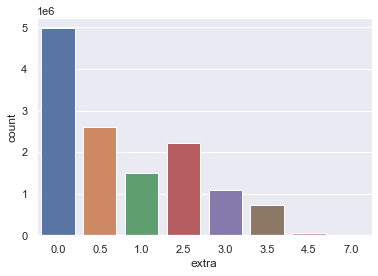

In [10]:
extra_list = list(df.extra.value_counts().keys()[:8])
df.loc[~df['extra'].isin(extra_list), 'extra'] = 0
del extra_list
sns.countplot(x='extra', data=df);

#### 2.1.C. MTA_tax (налог Управления городского транспорта)
$0.50 MTA tax that is automatically triggered based on the metered 
rate in use.

In [24]:
df.mta_tax.value_counts(dropna=False)

0.500     13056526
0.000        88766
-0.500       39330
0.870          202
3.300           18
0.900            5
3.000            5
0.350            2
30.800           1
1.100            1
6.800            1
0.850            1
2.800            1
1.540            1
2.500            1
Name: mta_tax, dtype: int64

Скорее, всего, отрицательные суммы -0.5 соответствуют возвратам. Для большего порядка все ненулевые значения тоже приведём к единой ставке налога $0.5, так как их совсем немного.

In [11]:
df.loc[df['mta_tax'] != 0.5, 'mta_tax'] = 0
df.mta_tax.value_counts()

0.500    13056526
0.000      128335
Name: mta_tax, dtype: int64

#### 2.1.D. tip_amount
This field is automatically populated for credit card tips. Cash tips are not included

In [26]:
df.tip_amount.describe()

count   13184861.000
mean           2.237
std            2.824
min         -200.800
25%            0.000
50%            1.950
75%            2.960
max         1100.000
Name: tip_amount, dtype: float64

In [27]:
df[df.tip_amount == df.tip_amount.max()]

VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
11164511     2.000  2020-01-22 16:41:24   2020-01-22 16:49:28   

          passenger_count  trip_distance  RatecodeID store_and_fwd_flag  \
11164511            1.000          0.550       1.000                  N   

          PULocationID  DOLocationID  payment_type  fare_amount  extra  \
11164511           231           209         1.000        6.500  1.000   

          mta_tax  tip_amount  tolls_amount  improvement_surcharge  \
11164511    0.500    1100.000         0.000                  0.300   

          total_amount  congestion_surcharge    month  
11164511      1110.800                 2.500  january

Сложно представить, что кто-то оставил бы 1100$ чаевых за 8 минут езды, однако, это не невозможно.

#### 2.1.E. tolls_amount
Total amount of all tolls paid in trip.

In [28]:
df.tolls_amount.value_counts().head(10)

0.000     12479292
6.120       641420
10.500        7947
2.800         7182
12.500        5668
12.240        4171
11.750        3911
13.750        2728
5.760         2244
17.500        1256
Name: tolls_amount, dtype: int64

В основном, конечно, в стоимость поездок не входят доп.сборы, но они бывают. Особенно частым выглядит тариф 6.12$. Интересно, почему?

In [29]:
df.groupby('RatecodeID')['tolls_amount'].median()

RatecodeID
1.000     0.000
2.000     6.120
3.000    13.750
4.000     0.000
5.000     0.000
6.000     0.000
99.000    0.000
Name: tolls_amount, dtype: float64

Значит, дороги в/из аэропорты им.Джона Кеннеди (JFK) и Нью-Джерси проходят по платному участку / с платной парковкой.

#### 2.1.F. improvement_surcharge
$0.30 improvement surcharge assessed trips at the flag drop.

In [30]:
df.improvement_surcharge.value_counts()

0.300     13135938
-0.300       40243
0.000         8680
Name: improvement_surcharge, dtype: int64

Казалось бы, самый бесполезный показатель. Но по нему можно почти со 100% уверенностью отфильтровать **возвраты**.

In [31]:
print(len(df[(df.improvement_surcharge < 0) & (df.total_amount >= 0)]))
# нет записей, в которых были бы возвраты с неотрицательным значением improvement_surcharge

0


In [32]:
df[(df.improvement_surcharge == 0) & (df.total_amount < 0)]

VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
1341161      2.000  2019-12-06 00:00:00   2019-12-06 18:55:44   
2646396      2.000  2019-12-11 22:32:17   2019-12-11 23:11:43   
7042692      2.000  2020-01-01 19:36:26   2020-01-01 19:36:26   
9903131      2.000  2020-01-16 12:35:58   2020-01-16 12:57:10   
10903081     2.000  2020-01-21 11:55:46   2020-01-21 11:55:46   
10937985     2.000  2020-01-21 15:21:43   2020-01-21 15:44:03   

          passenger_count  trip_distance  RatecodeID store_and_fwd_flag  \
1341161             1.000          0.000       1.000                  N   
2646396             2.000          0.000       5.000                  N   
7042692             2.000          0.000       5.000                  N   
9903131             1.000          0.000      99.000                  N   
10903081            1.000          0.000       5.000                  N   
10937985            1.000          1.670       1.000                  N   

          PULocationID  DOLocationID  payment_type  fare_amount  extra  \
1341161            264           264         3.000       -2.500  0.000   
2646396            132            93         3.000      -62.000  0.000   
7042692            264           264         3.000      -50.000  0.000   
9903131            193           193         3.000       -2.500  0.000   
10903081           264           264         3.000       -8.300  0.000   
10937985           107           229         2.000      -12.000  0.000   

          mta_tax  tip_amount  tolls_amount  improvement_surcharge  \
1341161     0.000       0.000         0.000                  0.000   
2646396     0.000       0.000         0.000                  0.000   
7042692     0.000       0.000         0.000                  0.000   
9903131     0.000       0.000         0.000                  0.000   
10903081    0.000       0.000         0.000                  0.000   
10937985    0.000       0.000         0.000                  0.000   

          total_amount  congestion_surcharge     month  
1341161         -4.000                 0.000  december  
2646396        -62.000                 0.000  december  
7042692        -50.000                 0.000   january  
9903131         -3.800                 0.000   january  
10903081        -8.300                 0.000   january  
10937985       -15.800                -2.500   january

Действительно, всего 6 поездок из 40 тысяч возвратов имели нулевое значение improvement_surcharge. Заменим в них 0 на -0.3 , думаю, это действие пригодится для классификации в будущем. А в остальных случаях - 0 на ставку 0.3 $

In [12]:
replace_list = [1341161, 2646396, 7042692, 9903131, 10903081, 10937985]
df.loc[df.index.isin(replace_list), 'improvement_surcharge'] = -0.3
df.loc[df['improvement_surcharge'] == 0, 'improvement_surcharge'] = 0.3
del replace_list
df.improvement_surcharge.value_counts()

0.300     13144612
-0.300       40249
Name: improvement_surcharge, dtype: int64

#### 2.1.G. congestion_surcharge
Доплата за пробку. Арифметически не является частью total_amount

In [35]:
df.congestion_surcharge.value_counts(dropna=False)

2.500     12138119
0.000      1014248
-2.500       32164
2.750          191
0.750          126
0.500            6
-0.750           2
-1.500           1
1.000            1
1.500            1
3.000            1
2.000            1
Name: congestion_surcharge, dtype: int64

Взимается почти всегда в размере 2.5 $. 

Чуть больше 300 зашумленных записей из 13 млн - заменим на единую ставку 2.5 $

In [13]:
df.loc[df['congestion_surcharge'] != 0, 'congestion_surcharge'] = 2.5
df.congestion_surcharge.value_counts()

2.500    12170613
0.000     1014248
Name: congestion_surcharge, dtype: int64

Теперь выведем обновлённую сумму общей стоимости. Чаевые сюда не включаем, т.к. это несколько субъективный показатель. Для возвратов новая общая сумма не актуальна, и впоследствии удалим эти записи. 

In [14]:
df['new_amount'] = df.fare_amount + df.extra + df.mta_tax + df.tolls_amount + df.improvement_surcharge + df.congestion_surcharge
df.head(1)

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0     1.000  2019-12-01 00:26:58   2019-12-01 00:41:45            1.000   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0          4.200       1.000                  N           142           116   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0         2.000       14.500  3.000    0.500       0.000         0.000   

   improvement_surcharge  total_amount  congestion_surcharge     month  \
0                  0.300        18.300                 2.500  december   

   new_amount  
0      20.800

#### Перейдём к рассмотрению остальных признаков в датасете 

### 2.2. Vendor ID
A code indicating the TPEP provider that provided the record.
- 1= Creative Mobile Technologies, LLC
- 2= VeriFone Inc

2.000    8807222
1.000    4377639
Name: VendorID, dtype: int64


Показатель: VendorID


2.000   0.668
1.000   0.332
Name: VendorID, dtype: float64

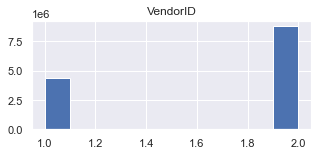

In [38]:
display(df.VendorID.value_counts(dropna=False))
ord_proport('VendorID')

Пропусков, а также явного перекоса в значений нет - 2/3 данных предоставлено VeriFone Inc

### 2.3. Pick Up & Drop Off Datetime
Время включения и выключения счётчика поездки

In [15]:
# Приведём данные к общему формату
df['tpep_pickup_datetime'] = pd.to_datetime(
    df.tpep_pickup_datetime, format='%Y-%m-%d %H:%M:%S', errors='coerce')
df['tpep_dropoff_datetime'] = pd.to_datetime(
    df.tpep_dropoff_datetime, format='%Y-%m-%d %H:%M:%S', errors='coerce')

# для подневной временной шкалы
df['dt_PU_date'] = df.tpep_pickup_datetime.dt.date
df['dt_DO_date'] = df.tpep_dropoff_datetime.dt.date

Учитывая, что год и месяц у нас представлены в единичном экзмемпляре, оставим только год. Дни и время разложим по элементам.

In [16]:
# 1. для начала поездок
df['dt_PU_year'] = df.tpep_pickup_datetime.dt.year
df['dt_PU_day'] = df.tpep_pickup_datetime.dt.day

df['dt_PU_hour'] = df.tpep_pickup_datetime.dt.hour
df['dt_PU_minute'] = df.tpep_pickup_datetime.dt.minute
df['dt_PU_second'] = df.tpep_pickup_datetime.dt.second

# 2. для окончания поездок
df['dt_DO_year'] = df.tpep_dropoff_datetime.dt.year
df['dt_DO_day'] = df.tpep_dropoff_datetime.dt.day

df['dt_DO_hour'] = df.tpep_dropoff_datetime.dt.hour
df['dt_DO_minute'] = df.tpep_dropoff_datetime.dt.minute
df['dt_DO_second'] = df.tpep_dropoff_datetime.dt.second

df.head(1)

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0     1.000  2019-12-01 00:26:58   2019-12-01 00:41:45            1.000   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0          4.200       1.000                  N           142           116   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0         2.000       14.500  3.000    0.500       0.000         0.000   

   improvement_surcharge  total_amount  congestion_surcharge     month  \
0                  0.300        18.300                 2.500  december   

   new_amount  dt_PU_date  dt_DO_date  dt_PU_year  dt_PU_day  dt_PU_hour  \
0      20.800  2019-12-01  2019-12-01        2019          1           0   

   dt_PU_minute  dt_PU_second  dt_DO_year  dt_DO_day  dt_DO_hour  \
0            26            58        2019          1           0   

   dt_DO_minute  dt_DO_second  
0            41            45

In [41]:
# Посмотрим на временные периоды в данных
display(df['dt_PU_year'].value_counts(dropna=False))
display(df['dt_DO_year'].value_counts(dropna=False))

2019    6845202
2020    6339561
2009         48
2008         40
2058          3
2021          3
2090          1
2066          1
2026          1
2003          1
Name: dt_PU_year, dtype: int64

2019    6843961
2020    6340802
2009         63
2008         25
2058          3
2021          3
2090          1
2066          1
2026          1
2003          1
Name: dt_DO_year, dtype: int64

Как видим, в нескольких поездках некорректно отобразился временной период (с 2003 года до далекого будущего). Удаляем эти выбросы, оставив только записи со стартом начала поездки в декабре или с завершением поездки в январе.

In [17]:
df.drop(df[(df.tpep_pickup_datetime < '2019-12-01 00:00:00') |
           (df.tpep_dropoff_datetime > '2020-01-31 23:59:59')].index, inplace=True)

In [18]:
gc.collect()

6479

Посмотрим на количество поездок по временной шкале.

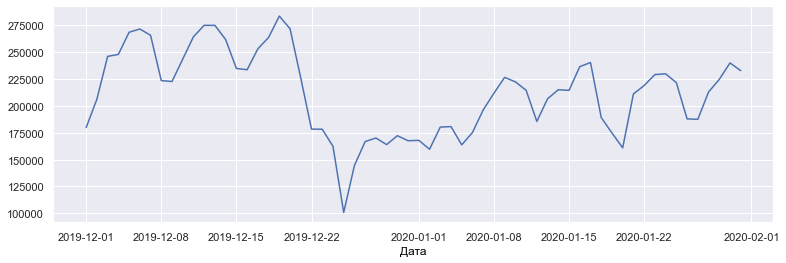

In [44]:
fig = plt.figure(figsize=(10, 3))
axes = fig.add_axes([0, 0, 1, 1])
axes.set_xlabel('Дата', fontsize=12, color='black')
axes.plot(sorted(df.dt_DO_date.unique()), df[df.improvement_surcharge > 0].groupby(
    'dt_DO_date')['VendorID'].count());

За три недели перед Рождеством количество поездок характерно описывало рабочие и выходные дни и планомерно нарастало. В канун Рождества почти никто никуда не ездил, и до Нового года общий уровень восстановился лишь на треть.  Любопытно, что заметное восстановление поездок произошло уже после 7 января. После этого снова заметна понедельная сезонность. 

Посмотрим на дневной трафик.

In [45]:
daily_traffic = df.groupby(['dt_DO_hour', 'dt_DO_date'], as_index=False)['VendorID'] \
    .agg({'VendorID' : 'count'}).rename({'VendorID' : 'total_rides'}, axis=1) \
    .groupby('dt_DO_hour', as_index=False)['total_rides'].agg({'total_rides' : 'mean'}) \
    .rename({'total_rides' : 'average_rides'}, axis=1)

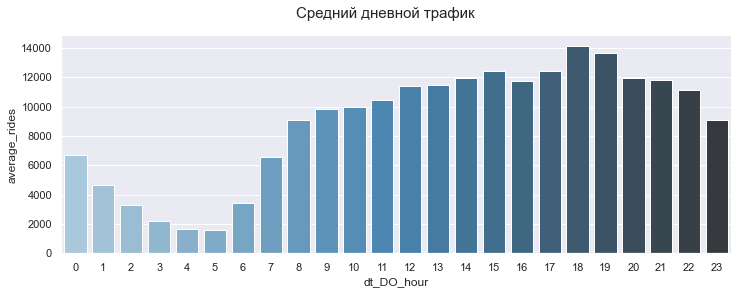

In [49]:
fig = plt.figure(figsize=(12, 4))
ax = sns.barplot(
    data=daily_traffic,
    x='dt_DO_hour',
    y='average_rides',
    palette="Blues_d")
fig.suptitle('Средний дневной трафик', fontsize=15)
sns.despine()
del daily_traffic
plt.show()

Часы пик чаще всего приходятся на окончание рабочего времени (с 18-19 ч), логично. 

Совместим подневный и почасовой трафик.

In [64]:
hours = df.pivot_table(
    index='dt_PU_date',
    columns='dt_PU_hour',
    values='VendorID',
    aggfunc='count'
)

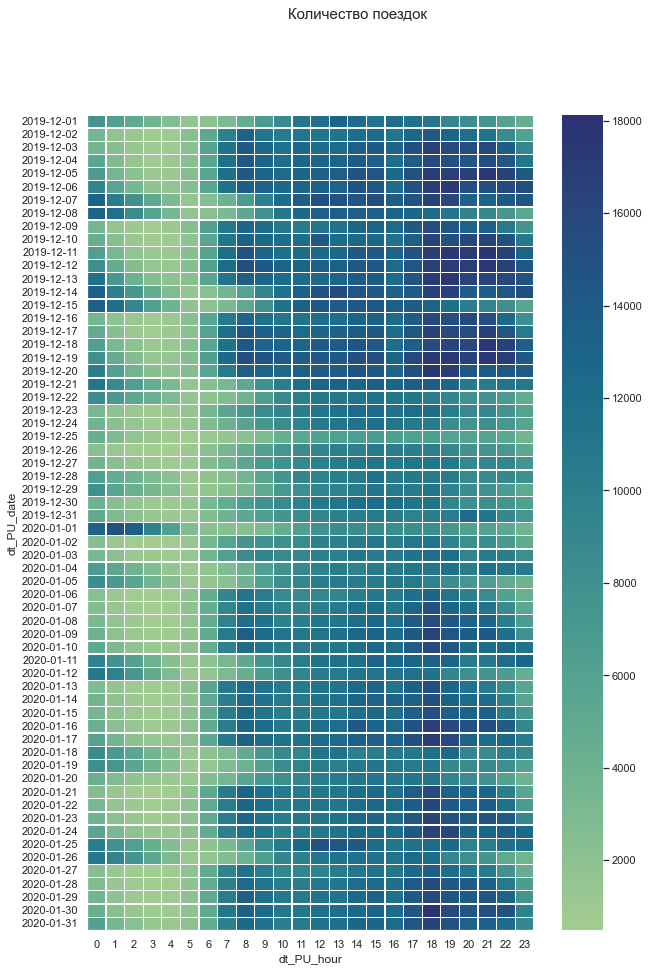

In [65]:
fig = plt.figure(figsize=(10, 15))
ax = sns.heatmap(
    data=hours,
    fmt='.1%',
    linewidths=0.25,
    cmap="crest"
)
fig.suptitle('Количество поездок', fontsize=15)
sns.despine()
del hours
plt.show()

- Хорошо заметен спад активности в рождественские каникулы. В этот период равномерно были поездки в промежуток м\д 11 и 19 часами. 
- В выходные достаточно много поездок до 2-3 часов ночи, после чего народ "вылазит" к 10-11 часам. 
- В будние дни количество поездок резко растёт в 7-8 утра. 
- Максимальное количество поездок совершается в пятницу с 18 до 19 часов.

Рассмотрим часы пик. 
В колонке extra имеется информация по дополнительной оплате за ночное время и часы пик. За час пик оплата равна 1 $. Выясним, в какое время обычно считается часом пик, и где ночной тариф. 

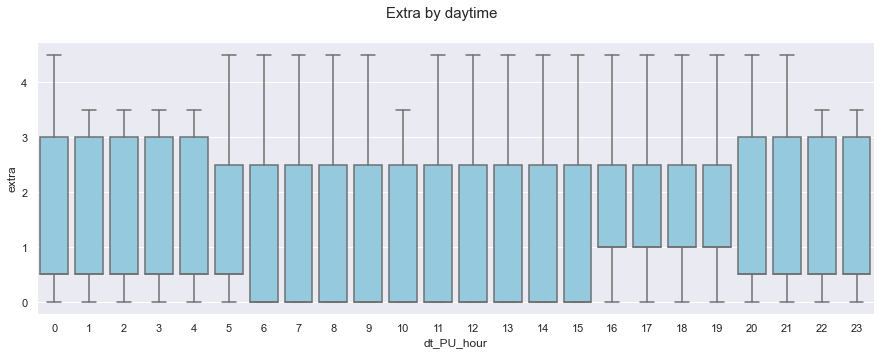

In [67]:
fig = plt.figure(figsize=(12, 4))
ax = sns.boxplot(
    data=df[df['extra'] < 5],
    x='dt_PU_hour',
    y='extra',
    color='skyblue'
)
fig.suptitle('Extra by daytime', fontsize=15)

sns.despine()
plt.show()

- C 20 ч до 5 утра медианное значение - 0.5 usd (ночной тариф). 
- С 16 ч по 19 медиана 1 usd, что соотвествует часам пик

Добавим новый признак - **продолжительность поездки**

In [19]:
df['duration_sec'] = (df['tpep_dropoff_datetime'] -
                      df['tpep_pickup_datetime']).dt.total_seconds().astype('int')

In [70]:
print(f'Максимальная продолжительность поездки составила: {round(df.duration_sec.describe()["max"]/60/60/24, 1)} суток')
print(f'Минимальная продолжительность поездки составила: {round(df.duration_sec.describe()["min"]/60/60/24, 1)} суток')

Максимальная продолжительность поездки составила: 4.2 суток
Минимальная продолжительность поездки составила: -4.0 суток


Слабо верится, поэтому с помощью стандартного отклонения этого признака посмотрим на аномально длительные поездки. А также удалим все записи с отрицательным значением duration, которых немного. 

In [20]:
print("отрицательных значений duration: ", len(df[df.duration_sec < 0]))
df.drop(df[df.duration_sec < 0].index, inplace=True)
print('deleted')

отрицательных значений duration:  2
deleted


In [72]:
outliers('duration_sec')


Вычислим границу выбросов для показателя duration_sec по среднему значению + 3 стандартных отклонения
Верхний предел duration_sec - 13045
Количество выбросов по данному признаку - 31311 или 0.2%


In [73]:
round(13045/3600, 1)

3.6

Однозначно сказать, что 3.6 часа пути - это строгая граница начала выбросов не получится. Поэтому, необходимо взять паузу и переключиться на признак дальности поездки (Trip Distance). В реальности могла случиться очень дальняя 4-х часовая поездка, или машина могла застрять в пробке. 

### 2.4. Trip_distance
The elapsed trip distance in miles reported by the taximeter.

In [75]:
df.trip_distance.describe()

count   13181788.000
mean           2.899
std            6.511
min          -23.010
25%            0.950
50%            1.600
75%            2.930
max        19130.180
Name: trip_distance, dtype: float64

In [76]:
print("отрицательных значений: ", len(df[df.trip_distance < 0]))
print("нулевых значений: ", len(df[df.trip_distance == 0]))
print("из них нулевых значений внутри одной и той же тарифной зоны: ", 
      len(df[(df.trip_distance == 0) & (df.PULocationID == df.DOLocationID)]))

отрицательных значений:  47
нулевых значений:  136661
из них нулевых значений внутри одной и той же тарифной зоны:  81112


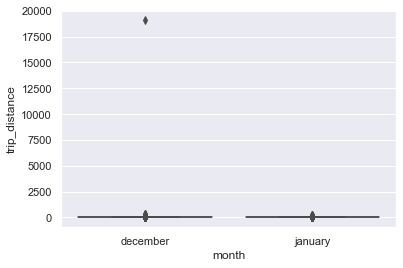

In [21]:
# Не задумываясь убираем поездки с отрицательным пробегом
df.drop(df[df.trip_distance < 0].index, inplace=True)

# Смотрим на значения
sns.boxplot(x='month', y='trip_distance', data=df);

Одна поездка сильно аномальная. Рассмотрим по-ближе

In [78]:
df[df.trip_distance > 2500]

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
704581     2.000  2019-12-04 10:20:13   2019-12-04 10:24:43            1.000   

        trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
704581      19130.180       5.000                  N           224   

        DOLocationID  payment_type  fare_amount  extra  mta_tax  tip_amount  \
704581           224         2.000       11.000  0.000    0.000       0.000   

        tolls_amount  improvement_surcharge  total_amount  \
704581         0.000                  0.300        11.000   

        congestion_surcharge     month  new_amount  dt_PU_date  dt_DO_date  \
704581                 0.000  december      11.300  2019-12-04  2019-12-04   

        dt_PU_year  dt_PU_day  dt_PU_hour  dt_PU_minute  dt_PU_second  \
704581        2019          4          10            20            13   

        dt_DO_year  dt_DO_day  dt_DO_hour  dt_DO_minute  dt_DO_second  \
704581        2019          4          10            24            43   

        duration_sec  
704581           270

По всем прочим параметрам, ничего необычного. Удалим воизбежание сильного влияния на среднее значение.

In [22]:
df.drop(df[df.trip_distance > 2500].index, inplace=True)

Нулевых значений тоже очень много, и они не кажутся правдоподобными. Создадим показатель **Route**, который будет означать комбинацию тарифных зон начала и окончания поездок (PULocationID, DOLocationID). При этом, маршруты направлений А-Б и Б-А отличаться не будут. Пропуски будем заполнять средним значением trip_distance внутри групп этих маршрутов.

In [23]:
df['route'] = np.maximum(df['PULocationID'], df['DOLocationID']).map(str) + "_" + \
                np.minimum(df['PULocationID'], df['DOLocationID']).map(str)

In [24]:
# словарь со средними значениями trip_distance внутри Route
routes_distances = dict(df.groupby('route')['trip_distance'].mean().round(2))

# мэппинг к датасету
df['avg_route_dist'] = df['route'].map(routes_distances)

# заполнение нулевых значений (нулевые с учётом округления)
df['trip_dist'] = np.where(df['trip_distance'] < 0.01, df['avg_route_dist'], df['trip_distance'])
df.loc[df.trip_dist < 0.01, 'trip_dist'] = round(df.trip_dist.mean(), 1)

In [82]:
outliers('trip_dist')


Вычислим границу выбросов для показателя trip_dist по среднему значению + 3 стандартных отклонения
Верхний предел trip_dist - 15
Количество выбросов по данному признаку - 425414 или 3.2%


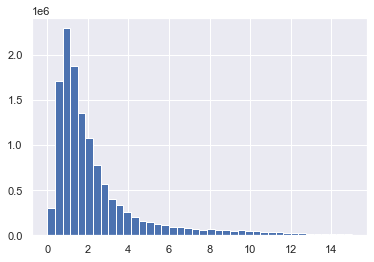

In [83]:
df[df.trip_dist <= 15].trip_dist.hist(bins=40);

Распределение не является нормальным и имеет правый хвост. Лучше будет логарифмировать этот показатель. 

In [25]:
df['log_distance'] = np.log(df['trip_dist'] + 1) # +1 воизбежание отрицательных значений

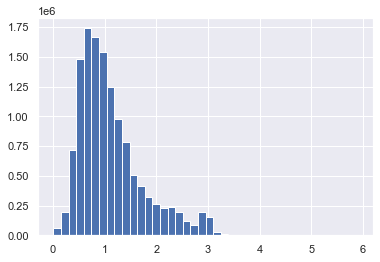

In [85]:
df.log_distance.hist(bins=40);

Немного лучше. Теперь, возвращаясь на несколько шагов назад, тем же самым способом заполним нулевые значения длительности поездки (duration_sec).

In [26]:
# словарь со средними значениями duration_sec внутри Route
routes_duration = dict(df.groupby('route')['duration_sec'].mean().round(2))

# мэппинг к датасету
df['avg_route_dur'] = df['route'].map(routes_duration)

# заполнение нулевых значений  
df['trip_duration'] = np.where(df['duration_sec'] < 1, df['avg_route_dur'], df['duration_sec'])
df.loc[df.trip_duration < 1, 'trip_duration'] = round(df.trip_duration.mean(), 1)

In [27]:
del routes_distances
del routes_duration

In [88]:
outliers('trip_duration')


Вычислим границу выбросов для показателя trip_duration по среднему значению + 3 стандартных отклонения
Верхний предел trip_duration - 13046
Количество выбросов по данному признаку - 31311 или 0.2%


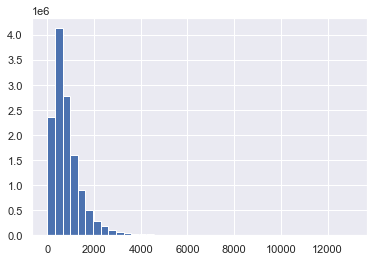

In [89]:
df[df.trip_duration <= 13046].trip_duration.hist(bins=40);

In [28]:
# Распределение с правым хвостом - логарифмируем данные
df['log_duration'] = np.log(df['trip_duration'] + 1) # воизбежание отрицательных значений

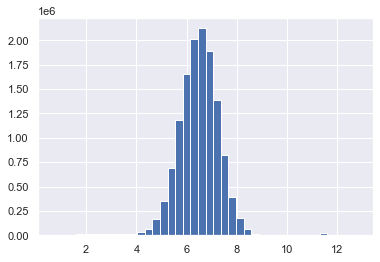

In [91]:
df.log_duration.hist(bins=40);

Немного лучше, но выбросы всё ещё остаются. Чтобы корректно оценить выбросы, необходимо к нашим данным добавить новый признак - ***среднюю скорость поездки***, равную отношению distance к duration. Для начала - логарифмированые значения.

In [29]:
df['log_speed'] = np.round(df['log_distance']/ df['log_duration'], 2)

In [93]:
outliers('log_speed')


Вычислим границу выбросов для показателя log_speed по среднему значению + 3 стандартных отклонения
Верхний предел log_speed - 1
Количество выбросов по данному признаку - 6576 или 0.0%


In [30]:
df.drop(df[df.log_speed  > 1].index, inplace=True)

Теперь очистим датасет с выбросами по обратному соотношению. 

In [31]:
df['log_sec_for_mile'] = np.round(df['log_duration']/ df['log_distance'], 1)
outlier = df['log_sec_for_mile'].describe()['mean'] + 3* df['log_sec_for_mile'].describe()['std']
df.drop(df[df.log_sec_for_mile  > outlier].index, inplace=True)
del outlier
print('Новая длина df: ', len(df))

Новая длина df:  13128623


Ещё можно просто оценить скорость в км/ч. 
Зная, что в штате Нью-Йорк действует ограничение скорости от 30 до 56 миль в час (48-90 км/ч), можно более корректно исключить неточные записи. 

In [32]:
df['avg_speed'] = np.round(df['trip_dist'] *1.609 / (df['trip_duration'] /3600), 1) # расчёт скорости с переводом в км/ч

In [98]:
len(df[df.avg_speed > 100])

78549

С одной стороны, терять данные не хочется, но для большей реальности всё-таки удалим черечур быстрые. 

In [33]:
df.drop(df[df.avg_speed > 100].index, inplace=True)

In [34]:
gc.collect()

3652

Перейдём к следующим признакам.

### 2.5. passenger_count
The number of passengers in the vehicle. This is a driver-entered value.

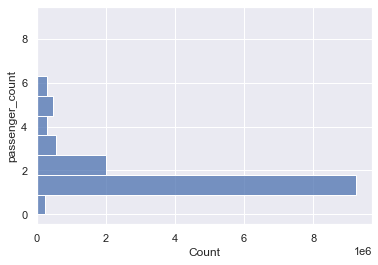

In [101]:
df.passenger_count.value_counts()
sns.histplot(data=df, y="passenger_count", bins=10);

In [102]:
Image(url= "http://www.blogcdn.com/www.autoblog.com/media/2012/09/nissan-nv-taxi-1348457409.jpg", width=400, height=200)

Из того, что удалось найти, наиболее вместительным автомобилем в таксопарке Нью-Йорка является минивэн Nissan NV200 с максимальным количеством пассажирских мест - 6. В связи с этим, данные с 7 по 9 кажутся завышенными, тем более по описанию водитель вручную вводит это значение, и могли быть ошибки ввода. "0" пассажиров, скорее всего, тоже является ошибкой. Поэтому все эти значения заменим для простоты на наиболее популярный вариант - 1.

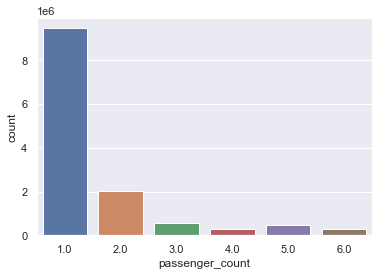

In [35]:
pass_list = [0,7,8,9]
df.loc[df['passenger_count'].isin(pass_list), 'passenger_count'] = 1
sns.countplot(x='passenger_count', data=df);

### 2.6.  Ratecode ID
The final rate code in effect at the end of the trip.

- 1 Standard rate
- 2 JFK
- 3 Newark
- 4 Nassau or Westchester
- 5 Negotiated fare
- 6 Group ride

In [104]:
df.RatecodeID.value_counts(dropna=False)

1.000     12655664
2.000       320290
5.000        33145
3.000        29931
4.000        10234
99.000         789
6.000           21
Name: RatecodeID, dtype: int64

Групповые поездки крайне редки. Также можно заметить, что в данных присутствует коэффициент 99, которого нет в словаре датасета. Несмотря на возможный выброс, удалять эти данные не будем.

### 2.7.  store_and_fwd_flag
This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.

- Y= store and forward trip
- N= not a store and forward trip

In [106]:
df.store_and_fwd_flag.value_counts()

N    12906856
Y      143218
Name: store_and_fwd_flag, dtype: int64

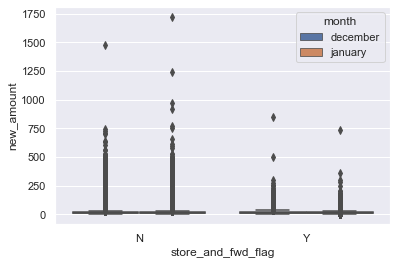

In [107]:
sns.boxplot(x='store_and_fwd_flag', y='new_amount', hue="month", data=df[df.new_amount > 0]);

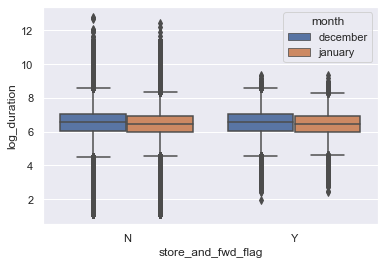

In [108]:
sns.boxplot(x='store_and_fwd_flag', y='log_duration', hue="month", data=df[df.new_amount > 0]);

In [35]:
gc.collect()

2748

Какой-то явной разницы по стоимости или длительности поездок у принципа S&F пока сложно увидеть.

### 2.8. Pick Up Location ID & Drop Off Location ID
Тарифные зоны начала и окончания поездок

Уникальных тарифных зон начала поездки:  261


array([142, 138, 161, 164,  79, 148, 186,  41, 132, 230,  68, 107,  48,
       229, 162, 140, 163, 114, 233, 255,  97,  45, 100,   4,  14, 249,
       146,   7, 158, 144,  90, 246, 264, 170, 234, 231, 113, 232,  50,
       239, 237, 141,  75, 236, 238, 152, 143,  87, 116, 137,  88, 263,
       211, 125,  13,  43, 179, 244, 226, 181, 166,  56,  74, 151, 189,
       112, 262, 194, 145, 168, 224, 256,  33,  80,  65, 209,  24, 167,
        82, 261, 193, 130,  10,  42, 254,  85, 265, 106, 182, 241,  25,
        40,  49, 173,  52, 225, 111,  71, 260,  83, 247, 223, 243,  62,
        36,  93,  39, 207,  77, 216,  31, 129,   8,  37, 215, 235, 157,
       219,  28,  95, 165, 228,  89, 217, 188, 198, 190, 127,  17,  61,
       197, 205, 122,  66, 184,  54,  92, 159,  35,  29, 120, 202, 160,
        63,  69,   6,  70,  11,  12,  76, 180,  51,   1, 133, 240, 171,
       135, 102, 220, 191, 119, 131, 213, 250, 134, 212, 196, 252,  72,
        21, 149, 210, 101,  38, 203, 169, 222,  91, 218, 139, 25

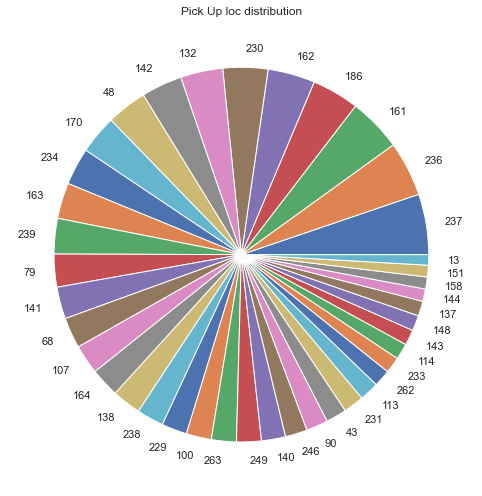

In [110]:
# Pick Up
print('Уникальных тарифных зон начала поездки: ', df.PULocationID.nunique())
display(df.PULocationID.unique())

# Посмотрим на распределение наиболее популярных зон Pick Up
df.groupby('PULocationID').size().sort_values(ascending=False)[:40].plot(kind='pie', subplots=True, figsize=(7, 7))
plt.title("Pick Up loc distribution")
plt.ylabel("")
plt.tight_layout()
plt.show()

Уникальных тарифных зон окончания поездки:  262


array([142, 138, 161, 164,  79, 148, 186,  41, 132, 230,  68, 107,  48,
       229, 162, 140, 163, 114, 233, 255,  97,  45, 100,   4,  14, 249,
       146,   7, 158, 144,  90, 246, 264, 170, 234, 231, 113, 232,  50,
       239, 237, 141,  75, 236, 238, 152, 143,  87, 116, 137,  88, 263,
       211, 125,  13,  43, 179, 244, 226, 181, 166,  56,  74, 151, 189,
       112, 262, 194, 145, 168, 224, 256,  33,  80,  65, 209,  24, 167,
        82, 261, 193, 130,  10,  42, 254,  85, 265, 106, 182, 241,  25,
        40,  49, 173,  52, 225, 111,  71, 260,  83, 247, 223, 243,  62,
        36,  93,  39, 207,  77, 216,  31, 129,   8,  37, 215, 235, 157,
       219,  28,  95, 165, 228,  89, 217, 188, 198, 190, 127,  17,  61,
       197, 205, 122,  66, 184,  54,  92, 159,  35,  29, 120, 202, 160,
        63,  69,   6,  70,  11,  12,  76, 180,  51,   1, 133, 240, 171,
       135, 102, 220, 191, 119, 131, 213, 250, 134, 212, 196, 252,  72,
        21, 149, 210, 101,  38, 203, 169, 222,  91, 218, 139, 25

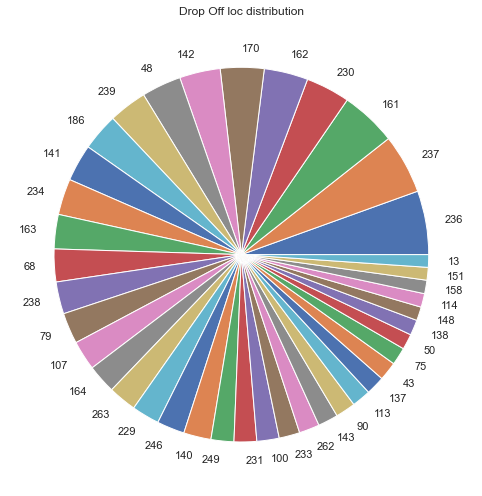

In [111]:
# Drop Off
print('Уникальных тарифных зон окончания поездки: ', df.DOLocationID.nunique())
display(df.PULocationID.unique())

# Посмотрим на распределение наиболее популярных зон Drop Off
df.groupby('DOLocationID').size().sort_values(ascending=False)[:40].plot(kind='pie', subplots=True, figsize=(7, 7))
plt.title("Drop Off loc distribution")
plt.ylabel("")
plt.tight_layout()
plt.show()

Пропусков в данных нет. Видно, что наиболее активными и популярными зонами являются 236, 237, 161, 162, 230. Остальные - плавно равномерно убывающие. 

In [112]:
# Наиболее частые комбинации маршрутов
df.route.value_counts().head(10)

237_236    174902
236_236     78710
239_142     77812
239_238     75910
237_237     72457
237_161     71608
230_186     70113
237_162     63971
236_141     63271
237_141     61988
Name: route, dtype: int64

### 2.9. payment_type
A numeric code signifying how the passenger paid for the trip. 
- 1= Credit card
- 2= Cash
- 3= No charge
- 4= Dispute
- 5= Unknown
- 6= Voided trip

In [113]:
display(df.payment_type.value_counts(dropna=False))

1.000    9505966
2.000    3456283
3.000      55704
4.000      32119
5.000          2
Name: payment_type, dtype: int64


Показатель: payment_type


1.000   0.728
2.000   0.265
3.000   0.004
4.000   0.002
Name: payment_type, dtype: float64

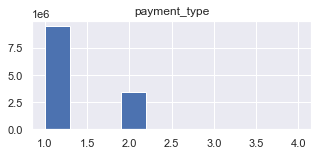

In [36]:
# В 2-х поездках с неизвестным типом платежа заменим признак на наиболее популярный - (1) Credit card
df.loc[df['payment_type'] == 5, 'payment_type'] = 1
ord_proport('payment_type')

Теперь можно удалить оставшиеся вспомогательные и неактуальные столбцы.

In [115]:
#df.head(1)

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0     1.000  2019-12-01 00:26:58   2019-12-01 00:41:45            1.000   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0          4.200       1.000                  N           142           116   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0         2.000       14.500  3.000    0.500       0.000         0.000   

   improvement_surcharge  total_amount  congestion_surcharge     month  \
0                  0.300        18.300                 2.500  december   

   new_amount  dt_PU_date  dt_DO_date  dt_PU_year  dt_PU_day  dt_PU_hour  \
0      20.800  2019-12-01  2019-12-01        2019          1           0   

   dt_PU_minute  dt_PU_second  dt_DO_year  dt_DO_day  dt_DO_hour  \
0            26            58        2019          1           0   

   dt_DO_minute  dt_DO_second  duration_sec    route  avg_route_dist  \
0            41            45           887  142_116           4.740   

   trip_dist  log_distance  avg_route_dur  trip_duration  log_duration  \
0      4.200         1.649       1509.150        887.000         6.789   

   log_speed  log_sec_for_mile  avg_speed  
0      0.240             4.100     27.400

In [37]:
remove_list = ['trip_distance', 'month', 'duration_sec', 
               'route', 'avg_route_dist', 'trip_dist', 
               'avg_route_dur', 'trip_duration', 'log_speed', 'log_sec_for_mile']

df.drop(remove_list, axis=1, inplace=True)
del remove_list
#df.head(1)

## Ответы на вопросы

На данном этапе мы уже можем ответить на часть поставленных вопросов.

- 1). Найдите аномальные поездки. Почему именно эти поездки вы считаете аномальными?

**В ходе разведывательного анализа данных мы нашли и устранили основную часть аномальных поездок в части стоимости, длительности, дальности и средней скорости, заменив данные на усреднённые показатели по маршруту следования.** 

Некоторые из них имели очень короткий период включения и выключения счётчика, при этом, начало и окончание тарифной зоны не менялось - можно предположить, что это были ошибочные запуски счётчика. 

Другие - наоборот, не выключались сутками. При этом, дальность либо была запредельной, либо слишком короткой. Возможно, счётчик не мог зарегистрировать окончание предыдущего запуска. 

- 2). Постройте распределение по стоимости поездок. Проверьте гипотезу о том, что оно имеет нормальное распределение. Как вы можете это объяснить?

**Посмотрим на очищенные данные по стоимости, за исключением возвратов, сфокусировавшись на достоверных данных.** Оставим за скобками возвраты, поездки дешевле 3.3$ (сумма обязательных налогов и сборов) и с общей стоимостью, сильно превышающей границу выбросов. 

In [118]:
df.new_amount.describe()

count   13050074.000
mean          17.394
std           12.529
min        -1472.300
25%           10.800
50%           13.800
75%           18.800
max         1722.300
Name: new_amount, dtype: float64

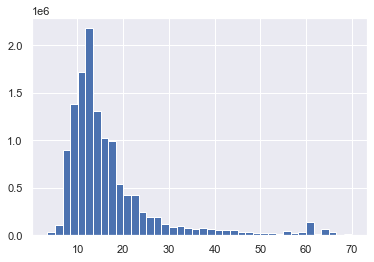

In [119]:
df[(df.new_amount < 70) & (df.new_amount > 3.3)]['new_amount'].hist(bins=40);

Распределение не является нормальным и имеет ***тяжёлый правый хвост***. Медианное значение 14$ - наиболее популярная стоимость поездки. В редких случаях поездки могут происходить на более дальние расстояния и стоить в несколько раз дороже. 

Возможно, для лучшего качества моделирования, стоит логарифмировать этот признак. 

In [38]:
df['log_amount'] = np.log(np.where(df['new_amount'] < 0, -1, 1) * df['new_amount'] + 1)

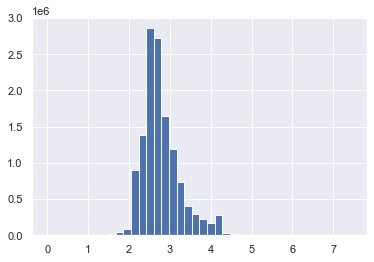

In [121]:
df.log_amount.hist(bins=40);

In [122]:
print('low border: ', round(df.log_amount.mean() - 3* df.log_amount.std(), 2))
print('up border: ', round(df.log_amount.mean() + 3* df.log_amount.std(), 2))

low border:  1.35
up border:  4.21


In [39]:
df.drop(df[(df.log_amount > 4.21) | (df.log_amount < 1.35)].index, inplace=True)

- 3). Как стоимость поездки скоррелирована с другими факторами? Как вы это можете объяснить?

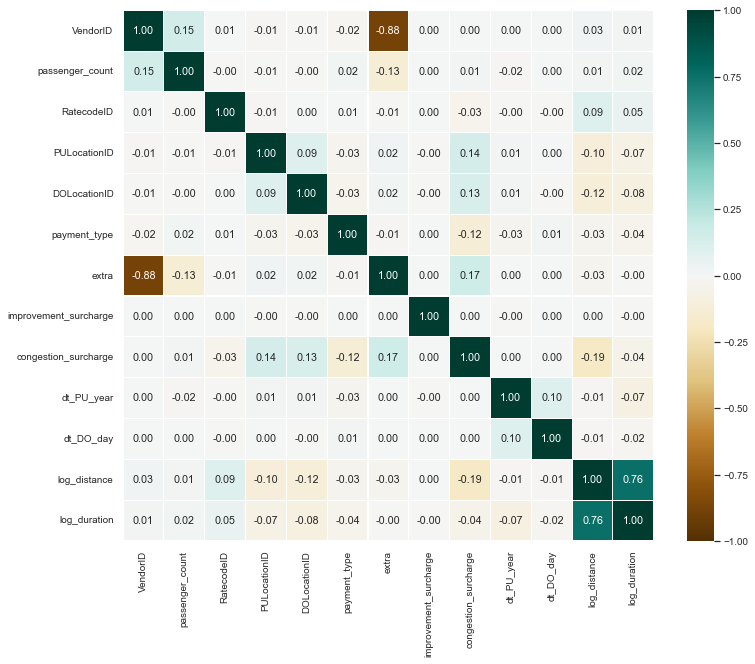

In [124]:
# Посмотрим корреляцию признаков

#x_corr = df.columns
# Планомерно исключаем взаимосвязанные переменные

x_corr = ['VendorID', 'passenger_count', 'RatecodeID', 'PULocationID', 'DOLocationID', 
          'payment_type', 'extra', 'improvement_surcharge', 'congestion_surcharge', 
          'dt_PU_year', 'dt_DO_day', 'log_distance', 'log_duration']

corr = df[df['improvement_surcharge'] > 0][x_corr].corr()

sns.set(font_scale=0.9)
plt.subplots(figsize=(10, 8))
plt.tight_layout()
sns.heatmap(corr, square=True, vmin=-1, vmax=1,
            annot=True, fmt=".2f", linewidths=0.1, cmap="BrBG");

Очевидно, что чем дальше поездка, тем она длиннее по времени, и тем она дороже. И чем поездка дальше, тем реже взимается плата за пробку.  

Неочевидной, но очень сильной взаимосвязью обладают тип вендора и размер доп.платежей. 

Так же в ходе EDA мы уже обнаружили, что данные о возвратах сильно характерны для Dispute и No_charge. 

- 4). Были ли в какие-то дни (или временные промежутки) скидки или акции? И если были, то как вы можете это объяснить.

**Попробуем заранее проверить эту информацию, основываясь на тепловой карте среднего чека поездок по дням и времени.**

In [126]:
avg_bill = df.pivot_table(
    index='dt_PU_date',
    columns='dt_PU_hour',
    values='new_amount',
    aggfunc='mean'
)

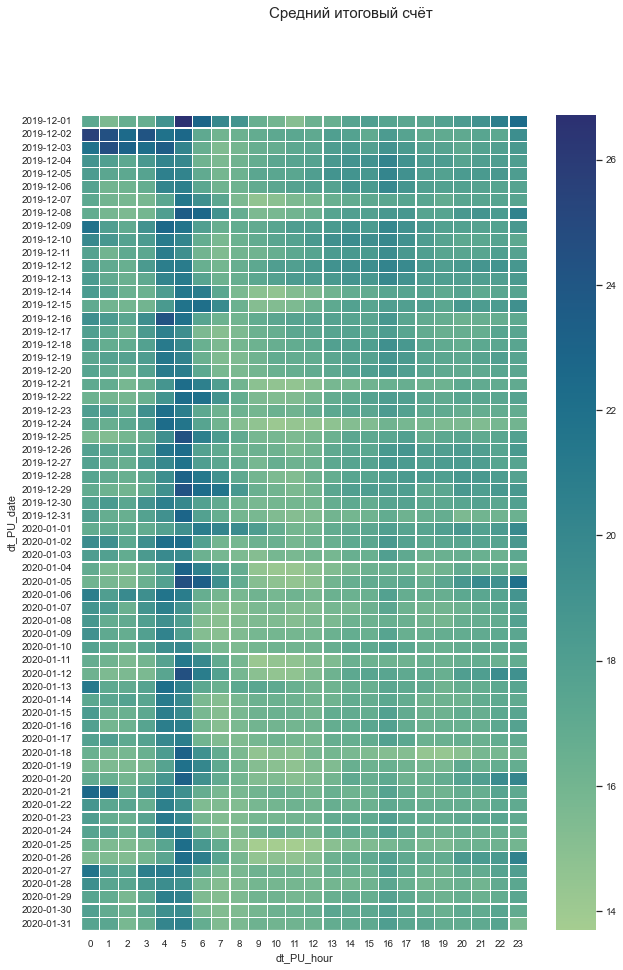

In [127]:
fig = plt.figure(figsize=(10, 15))
ax = sns.heatmap(
    data=avg_bill,
    fmt='.1%',
    linewidths=0.25,
    cmap='crest'
)
fig.suptitle('Средний итоговый счёт', fontsize=15)
sns.despine()
del avg_bill
plt.show()

Здесь, кажется, **есть определённая закономерность в выходные дни** (напр. 7-8, 14-15, 21-22 декабря и т.д.). Средний чек заметно ниже в утренние часы, с 9 до 11. В канун Рождества весь день средний чек был ниже других дней.  При этом заметно насколько дорого ездить в предрассветное время, с 4 до 6 утра.

## 3. Feature Engineering

Мы уже добавили некоторые вспомогательные переменные (скорость, маршрут, логарифмы величин и др.). Попробуем добавить ещё несколько

По своей сути, время (часы, минуты, секунды, дни недели и т.п.) - цикличные величины. И 23:59 ч по сути близко к 00:01, а 31 число - к 1-му, однако, модель может этого не учесть. Поскольку время рассматриваем в 24-часовом формате, мы можем представить время в секундах после полуночи.

**3.1. Время и даты Pick Up "на круг"**

In [40]:
gc.collect()

6015

In [41]:
# Секунды от полуночи
df['PU_sec_past_midnight'] = (df.dt_PU_hour*3600 + df.dt_PU_minute*60 + df.dt_PU_second).astype('int')

Теперь создадим две новые функции sin и cos, производя преобразование секунд после полуночи.

In [42]:
seconds_in_day = 24*60*60

df['PU_sin_time'] = np.sin(2*np.pi*df.PU_sec_past_midnight/seconds_in_day)
df['PU_cos_time'] = np.cos(2*np.pi*df.PU_sec_past_midnight/seconds_in_day)

df.drop(['tpep_pickup_datetime', 'dt_PU_hour', 'dt_PU_minute',
         'dt_PU_second', 'PU_sec_past_midnight', ], axis=1, inplace=True)

Полученная цикличность времени примерно выглядит так:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


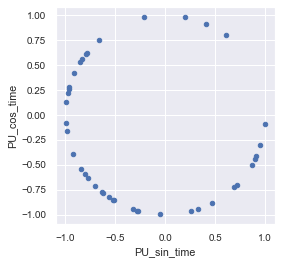

In [130]:
df.sample(40).plot.scatter('PU_sin_time', 'PU_cos_time').set_aspect('equal');

Таким же образом мы можем зациклить числа месяца. Тем более в декабре и январе одинаково 31 день. 

In [43]:
df['PU_sin_day'] = np.sin(2*np.pi*df.dt_PU_day/31)
df['PU_cos_day'] = np.cos(2*np.pi*df.dt_PU_day/31)

df.drop('dt_PU_day', axis=1, inplace=True)

**3.2. Время Drop Off "на круг"**

Дату окончания поездки обрабатывать не будем воизбежание сильной корреляции.

In [44]:
# Секунды от полуночи
df['DO_sec_past_midnight'] = (
    df.dt_DO_hour*3600 + df.dt_DO_minute*60 + df.dt_DO_second).astype('int')

seconds_in_day = 24*60*60

df['DO_sin_time'] = np.sin(2*np.pi*df.DO_sec_past_midnight/seconds_in_day)
df['DO_cos_time'] = np.cos(2*np.pi*df.DO_sec_past_midnight/seconds_in_day)

df.drop(['tpep_dropoff_datetime', 'dt_DO_hour', 'dt_DO_minute',
         'dt_DO_second', 'DO_sec_past_midnight'], axis=1, inplace=True)

df.head(1)

VendorID  passenger_count  RatecodeID store_and_fwd_flag  PULocationID  \
0     1.000            1.000       1.000                  N           142   

   DOLocationID  payment_type  fare_amount  extra  mta_tax  tip_amount  \
0           116         2.000       14.500  3.000    0.500       0.000   

   tolls_amount  improvement_surcharge  total_amount  congestion_surcharge  \
0         0.000                  0.300        18.300                 2.500   

   new_amount  dt_PU_date  dt_DO_date  dt_PU_year  dt_DO_year  dt_DO_day  \
0      20.800  2019-12-01  2019-12-01        2019        2019          1   

   log_distance  log_duration  avg_speed  log_amount  PU_sin_time  \
0         1.649         6.789     27.400       3.082        0.117   

   PU_cos_time  PU_sin_day  PU_cos_day  DO_sin_time  DO_cos_time  
0        0.993       0.201       0.980        0.181        0.983

**3.3. Дни недели и уикенды**

In [44]:
#gc.collect()

3214

In [45]:
df['day_of_week'] = pd.to_datetime(df['dt_PU_date']).dt.dayofweek + 1
df['weekend'] = np.where(df['day_of_week'] >= 6, 1, 0)

In [46]:
df['dow_sin'] = np.sin(2*np.pi*df.day_of_week/7)
df['dow_cos'] = np.cos(2*np.pi*df.day_of_week/7)

df.drop('day_of_week', axis=1, inplace=True)

### Признак наличия возвратов
Для начала создадим ключ, который будет уникальным для обыкновенной поездки, и будет дублироваться в датасете в случае наличия возвратов.

In [140]:
'''
Это упражнение занимает очень много памяти и не всегда удаётся его выполнить, но оно может быть действенным


df['refund_key'] = df.dt_PU_date.map(str) + "_" + df.PU_sin_time.round(5).map(str) + "_" + \
    df.PU_cos_time.round(5).map(str) + "_" + df.dt_DO_date.map(str) + "_" + \
    df.DO_sin_time.round(5).map(str) + "_" + df.DO_cos_time.round(5).map(str) + "_" + \
    df['PULocationID'].map(str) + "_" + df['DOLocationID'].map(str) + "_" + \
    df.VendorID.map(str) + "_" + df.passenger_count.map(str) + \
    "_" + df.RatecodeID.map(str)

In [141]:
'''
# словарь с повторяющимися значениями
refund_dict = dict(df.refund_key.value_counts())

# мэппинг к датасету
df['refund'] = df['refund_key'].map(refund_dict)
del refund_dict

In [47]:
gc.collect()

83

In [ ]:
#df.drop('refund_key', axis=1, inplace=True)

In [145]:
#df.improvement_surcharge.value_counts()

0.300     12932733
-0.300       19774
Name: improvement_surcharge, dtype: int64

In [48]:
df.drop(df[df.improvement_surcharge < 0].index, inplace=True)

В итоге мы очистили датасет от отрицательных списаний, сохранив признак возврата.  

### LabelEncoder

In [49]:
df.head(1)

VendorID  passenger_count  RatecodeID store_and_fwd_flag  PULocationID  \
0     1.000            1.000       1.000                  N           142   

   DOLocationID  payment_type  fare_amount  extra  mta_tax  tip_amount  \
0           116         2.000       14.500  3.000    0.500       0.000   

   tolls_amount  improvement_surcharge  total_amount  congestion_surcharge  \
0         0.000                  0.300        18.300                 2.500   

   new_amount  dt_PU_date  dt_DO_date  dt_PU_year  dt_DO_year  dt_DO_day  \
0      20.800  2019-12-01  2019-12-01        2019        2019          1   

   log_distance  log_duration  avg_speed  log_amount  PU_sin_time  \
0         1.649         6.789     27.400       3.082        0.117   

   PU_cos_time  PU_sin_day  PU_cos_day  DO_sin_time  DO_cos_time  weekend  \
0        0.993       0.201       0.980        0.181        0.983        1   

   dow_sin  dow_cos  
0   -0.000    1.000

In [49]:
# Кодируем категориальные признаки
x_label = ['passenger_count', 'store_and_fwd_flag', 'weekend'] # , 'refund']

label_encoder = LabelEncoder()
for col in x_label:
    df[col] = label_encoder.fit_transform(df[col])

### Dummy-переменные

In [50]:
x_dummy = ['VendorID', 'RatecodeID', 'payment_type', 'dt_PU_year', 'dt_DO_year']

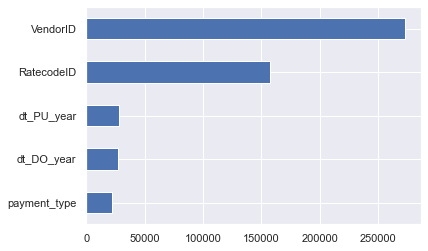

In [51]:
# Проверка значимости 
check_X = df[x_dummy]
check_Y = df['log_amount']

imp_num = Series(f_regression(check_X, check_Y)[0], index = x_dummy)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

In [52]:
x_dummies = []
for col in x_dummy:
    df_dumm = pd.get_dummies(df[col], dummy_na=False, prefix=col).astype('float64')
    df = pd.concat([df, df_dumm], axis=1)
    del df_dumm
del x_dummies

In [88]:
#df.columns

## 4. Подготовка модели

In [72]:
x_label = ['passenger_count', 'store_and_fwd_flag'] #убрать лишний weekend

In [73]:
x_final = x_label + list(df.columns[-26:]) + ['PULocationID', 'DOLocationID',
                                              'log_distance', 'log_duration']
del x_dummy
del x_label
x_final

['passenger_count',
 'store_and_fwd_flag',
 'PU_sin_time',
 'PU_cos_time',
 'PU_sin_day',
 'PU_cos_day',
 'DO_sin_time',
 'DO_cos_time',
 'weekend',
 'dow_sin',
 'dow_cos',
 'VendorID_1.0',
 'VendorID_2.0',
 'RatecodeID_1.0',
 'RatecodeID_2.0',
 'RatecodeID_3.0',
 'RatecodeID_4.0',
 'RatecodeID_5.0',
 'RatecodeID_6.0',
 'RatecodeID_99.0',
 'payment_type_1.0',
 'payment_type_2.0',
 'payment_type_3.0',
 'payment_type_4.0',
 'dt_PU_year_2019',
 'dt_PU_year_2020',
 'dt_DO_year_2019',
 'dt_DO_year_2020',
 'PULocationID',
 'DOLocationID',
 'log_distance',
 'log_duration']

Для более быстрого обучения придётся сильно уменьшить выборки.

In [74]:
gc.collect()

208

In [75]:
from sklearn.model_selection import train_test_split

X = df[x_final]
y = df['log_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, shuffle=True, random_state=random_seed)
del X, y
#del X_test, y_test

X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(X_train, y_train, test_size=0.33, random_state=random_seed)
#del X_train, X_test

X_s_train.shape, X_s_test.shape

((2166232, 32), (1066951, 32))

In [76]:
params = {
    'max_depth': 7,
    'gamma': 0,
    'eta': .03,
    'subsample': 1,
    'colsample_bytree': 0.9,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 0
}

matrix_train = xg.DMatrix(X_s_train, label=y_s_train)
matrix_test = xg.DMatrix(X_s_test, label=y_s_test)

In [78]:
from datetime import datetime as dt

In [79]:
start_time = dt.now()
model = xg.train(params=params, dtrain=matrix_train, num_boost_round=300,
                 early_stopping_rounds=5, evals=[(matrix_test, 'test')])

[00:28:39] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[00:28:39] WARNING: ..\src\learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	test-rmse:2.24776
[1]	test-rmse:2.18033
[2]	test-rmse:2.11517
[3]	test-rmse:2.05173
[4]	test-rmse:1.99170
[5]	test-rmse:1.93212
[6]	test-rmse:1.87424
[7]	test-rmse:1.81824
[8]	test-rmse:1.76371
[9]	test-rmse:1.71102
[10]	test-rmse:1.65983
[11]	test-rmse:1.61018
[12]	test-rmse:1.56201
[13]	test-rmse:1.51536
[14]	test-rmse:1.47003
[15]	test-rmse:1.42620
[16]	test-rmse:1.38367
[17]	test-rmse:1.34234
[18]	test-rmse:1.30228
[19]	test-rmse:1.26347
[20]	test-rmse:1.22573
[21]	test-rmse:1.18915
[22]	test-rmse:1.153

In [80]:
print("Training time: %i seconds with %i training examples" %
      ((dt.now()-start_time).total_seconds(), len(y_s_train)))

Training time: 1789 seconds with 2166232 training examples


In [81]:
y_pred = model.predict(xg.DMatrix(X_s_test))

In [84]:
print('MAE:', round(mean_absolute_error(y_s_test, y_pred), 3))  
print('MSE:', round(mean_squared_error(y_s_test, y_pred), 3))  
print('RMSE:', round(np.sqrt(mean_squared_error(y_s_test, y_pred)), 3))
print('VarScore:', round(explained_variance_score(y_s_test, y_pred), 3))

MAE: 0.027
MSE: 0.003
RMSE: 0.054
VarScore: 0.986


In [85]:
fscores = pd.DataFrame({'X': list(model.get_fscore().keys()), 'Y': list(model.get_fscore().values())})
fscores.sort_values('Y',ascending=True,inplace=True)

In [87]:
fig = go.Figure()
fig.add_traces(go.Bar(x=fscores.Y))
fig.update_yaxes(ticktext=fscores.X, tickvals=list(range(25)))
fig.update_layout(xaxis_title='Feature Importance',
                  title='Predicting Taxi Fares with XGBoost')
fig.update_layout(yaxis={'categoryorder': 'total ascending'})

Модель неплохо себя проявила и далее можно пробовать обучить более крупные объёмы данных. 

Ещё можно попробовать провести потенцирование целевой переменной и обратную декодировку фич sin-cos дат в реальные даты и на графике сравнить отличие y_pred и y_test по временным признакам. Так было бы очевиднее, когда тарифы могли сильно отличаться от прогнозных. 